In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
# import jax 
# import numpyro 
# from getdist import plots, MCSamples
# import getdist
import glob
from astropy.io import fits
import astropy.units as u
import astropy.constants as con
from scipy.integrate import quad
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median
import jax.numpy as jnp

In [2]:
data = pd.read_csv("data/jla_lcparams.txt", sep=" ", header=0)
covariance = np.load('data/covariance.npz')['arr_0'] 

In [3]:
columns = ['zcmb', 'mb', 'dmb', '3rdvar', 'x1', 'color']
data_filtered = data[columns]
data_filtered.columns = ['z', 'mb', 'delta_M', 'M_stel', 'X1', 'C']
inputs = data_filtered[["z", "M_stel", "X1", "C"]].values

In [4]:
z = data_filtered['z']
mb = data_filtered['mb']
delta_M = data_filtered['delta_M']
M_stel = data_filtered['M_stel']
X1 = data_filtered['X1']
C = data_filtered['C']

#mb is peak magnitude
#zcmb is redshift
#3rdvar is log10 host stellar mass
#x1 is SALT2 shape parameter
#color is color parameter

In [5]:
z_arr = np.asarray(data_filtered['z'])
mb_arr = np.asarray(mb)
delta_M_arr = np.asarray(delta_M)
Mstel_arr = np.asarray(M_stel)*10**10
X1_arr = np.asarray(X1)
C_arr = np.asarray(C)

In [6]:
# If M_Stel is greater than 10^10 Msun, then the Heaviside function is 1.
# If M_stel is less than 10^10 Msun, then it's 0.

In [7]:
def heavyside(M_stel):
    SM10 = 10**10
    if M_stel> SM10:
         hev_f = 0
    else:
         hev_f = 1
    return hev_f

def absfunc(M_stel, hev_f, M_B, delta_m):
    #modified_M_B = M_B + delta_m * (M_stel - SM10)
    #modified_M_B = M_B + delta_m * (M_stel.to(u.Msun).value - SM10.value)
    return modified_M_B

In [8]:
def hgalaxy(M_stel,M_B, delta_m):
    SM10=10**10
    #The absolute magnitude is dependent on properties of the hgalaxy
    hev_f=heavyside(M_stel)
    absmag = M_B + delta_m * hev_f 
    return absmag

In [9]:
def integrand(z,Om_m, w0):
        p1 = (1 + z)**3
        p2 = (1 - Om_m)
        p3 = (Om_m * p1) + p2 * (p1)**(3*(w0 + 1))
        squared = np.sqrt(p3)
        return 1 / squared   #returns the value of the integrand
    
def D_L(zs,Om_m=0.315,w0=-1,H0=(70*u.km)/u.s/u.Mpc):
    factor = con.c.to(u.km/u.s) * (1 + zs) / H0
    #factor = con.c.value * (1 + zs) / H0
    z = np.linspace(0, zs, num=500)
    integ = np.trapz(integrand(z, Om_m, w0), z)
    return factor * integ

In [10]:
def main(Om_m, z, w0, M_B, M_stel, delta_m, alpha, beta, X1, C):  #Making a function that takes in values for these parameters

    Lum_dist = D_L(z,Om_m, w0) #Using Luminosity distance function in main, which uses integrand inside

    hev_f=heavyside(M_stel)
    pt1 = 5*np.log10((Lum_dist)/(10*u.pc))      #5log10D*L/10pc
    pt2 = hgalaxy(M_stel, M_B, delta_m)         #This should give the return of absfunc which is modified_M_B
    # pt3 = ((alpha * X1) + (beta * C))                  #Last part of the equation
    
    app_mag = pt1 + pt2 - (alpha*X1) +(beta*C)    #Putting it all together
    
    return app_mag

In [11]:
#main(Om_m, z, w0, M_B, M_stel, absmag, alpha, beta, X1, C): 
Om_m = 0.315
w0 = -1
# M_stel = 19.3
alpha = 0.1257
beta = 2.644
M_B = -19.3
delta_m = -0.061
SM10=10**10

In [12]:
main(Om_m, z_arr[1], w0, M_B, Mstel_arr[1], delta_m, alpha, beta, X1[1], C[1])

<Quantity 23.15153357>

In [13]:
mB_final= 5*np.log10(((D_L(z_arr[1],Om_m,w0))/(10*u.pc))) + hgalaxy(Mstel_arr[1],M_B,delta_m)-(alpha*X1_arr[1])+(beta*C_arr[1])
mB_final

<Quantity 23.15153357>

In [14]:
z = 0.5
D_L_value = D_L(z)
print(f"D_L(z={z}) = {D_L_value}, Units = {D_L_value.unit}")

D_L(z=0.5) = 2818.3603538886446 Mpc, Units = Mpc


In [15]:
df = pd.DataFrame(columns=['magnitude'])

for i in range (len(z_arr)):
    # D_L_value = D_L(z_arr[i])
    # D_L_value_in_parsecs = D_L_value.to(u.pc).value

    finalvals=main(Om_m, z_arr[i], w0, M_B, Mstel_arr[i], delta_m, alpha, beta, X1[i], C[i])
    
    # # calculating the apparent magnitude
    # mB_finalvals = 5 * np.log10((D_L_value_in_parsecs * 10**6)/ 10)
    #mB_finalvals = 5 * np.log10(D_L_value * 10**6 / 10)
    new_row = {'magnitude': finalvals}
    df.loc[len(df)] = new_row
#print(mb_arr)
print(df)


              magnitude
0    22.773244938502398
1     23.15153357179947
2    22.750883094594275
3     22.04417135678072
4    23.564512960869923
..                  ...
735   16.36026502689823
736  15.851965273727753
737   15.55691733518742
738  15.828858054431313
739  15.457855440729777

[740 rows x 1 columns]


In [16]:
columns = ['zcmb', 'mb', 'dmb', '3rdvar', 'x1', 'color']
data_filtered = data[columns]
data_filtered.columns = ['z', 'mb', 'delta_M', 'M_stel', 'X1', 'C']

z = data_filtered['z']
mb = data_filtered['mb']
delta_M = data_filtered['delta_M']
M_stel = data_filtered['M_stel']
X1 = data_filtered['X1']
C = data_filtered['C']


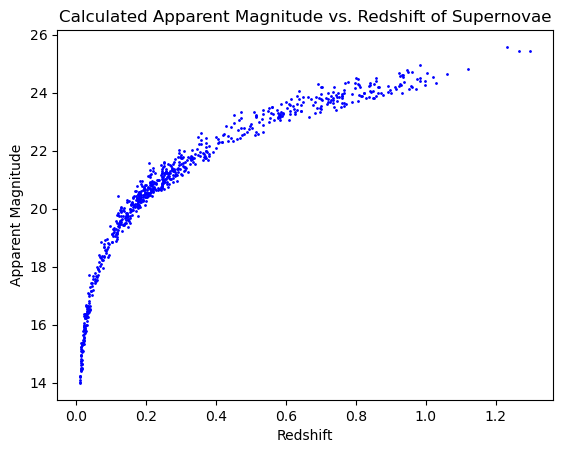

In [17]:
magnitudes = df['magnitude']

plt.scatter(z_arr, magnitudes, c='b', s=1) #plt.scatter(x, y, c='r', s=1)
plt.title('Calculated Apparent Magnitude vs. Redshift of Supernovae')
plt.ylabel('Apparent Magnitude')
plt.xlabel('Redshift')
plt.show()

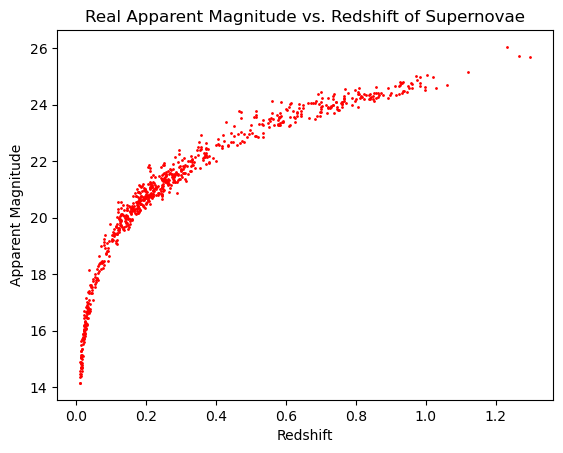

In [18]:
x = z
y = mb
plt.scatter(x, y, c='r', s=1)
plt.title('Real Apparent Magnitude vs. Redshift of Supernovae')
plt.ylabel('Apparent Magnitude')
plt.xlabel('Redshift')
plt.gca()
plt.show()

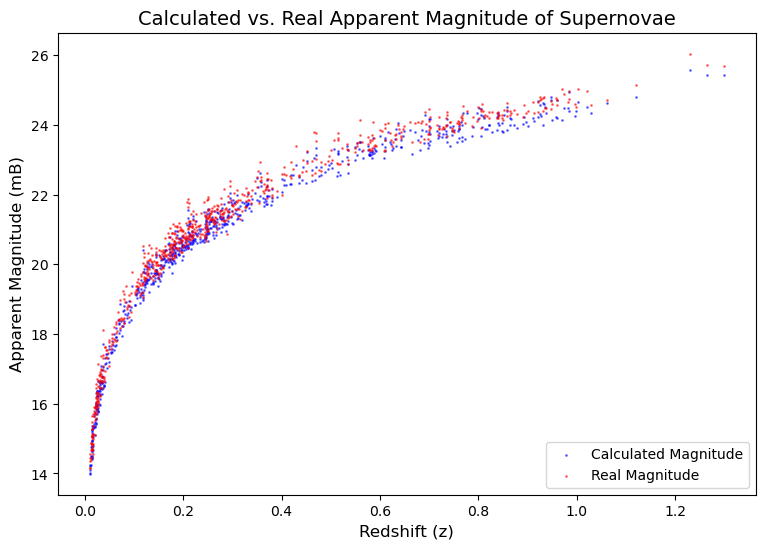

In [19]:
plt.figure(figsize=(9, 6))

# plot calculated magnitudes
plt.scatter(z_arr, magnitudes, c='b', s=1, label='Calculated Magnitude', alpha=0.5)  # blue for calculated magnitudes

# plot real magnitudes
plt.scatter(x, y, c='r', s=1, label='Real Magnitude', alpha=0.5)  # red for real magnitudes


plt.title('Calculated vs. Real Apparent Magnitude of Supernovae', fontsize=14)
plt.ylabel('Apparent Magnitude (mB)', fontsize=12)
plt.xlabel('Redshift (z)', fontsize=12)

plt.legend(loc='lower right', frameon=True)

plt.show()


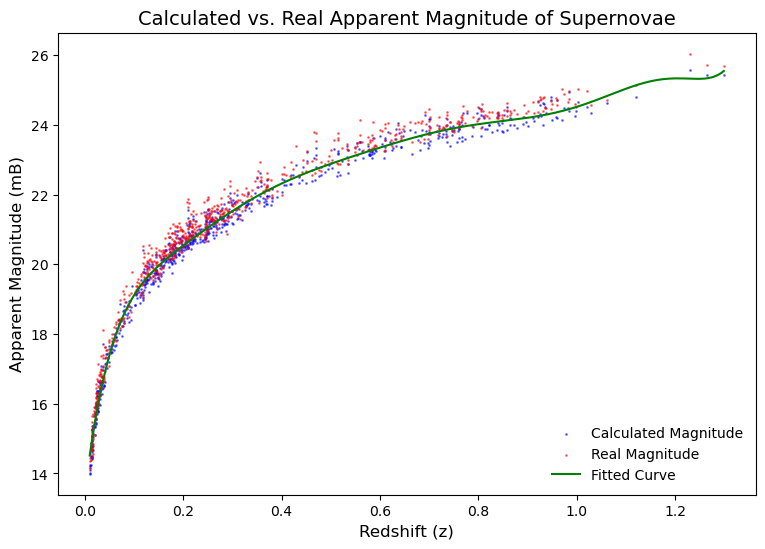

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure arrays are of correct dtype
if z_arr.dtype == 'O':
    z_arr = z_arr.astype(float)
if magnitudes.dtype == 'O':
    magnitudes = magnitudes.astype(float)

# Plot settings
plt.figure(figsize=(9, 6))

# Scatter plot of calculated magnitudes
plt.scatter(z_arr, magnitudes, c='b', s=1, label='Calculated Magnitude', alpha=0.5)

# Scatter plot of real magnitudes
plt.scatter(x, y, c='r', s=1, label='Real Magnitude', alpha=0.5)

# Polynomial fitting of calculated magnitudes
order = 9
fit = np.polyfit(z_arr, magnitudes, order)
model = np.poly1d(fit)
polyline = np.linspace(min(z_arr), max(z_arr), 250)

# Plot polynomial fit line
plt.plot(polyline, model(polyline), color='green', label='Fitted Curve')

plt.title('Calculated vs. Real Apparent Magnitude of Supernovae', fontsize=14)
plt.ylabel('Apparent Magnitude (mB)', fontsize=12)
plt.xlabel('Redshift (z)', fontsize=12)
plt.legend(loc='lower right', frameon=False)

plt.show()


Histograms of Redshift (zcmb), Apparant Magnitude (mb), Stretch Parameter (x1), Color Parameter (color)

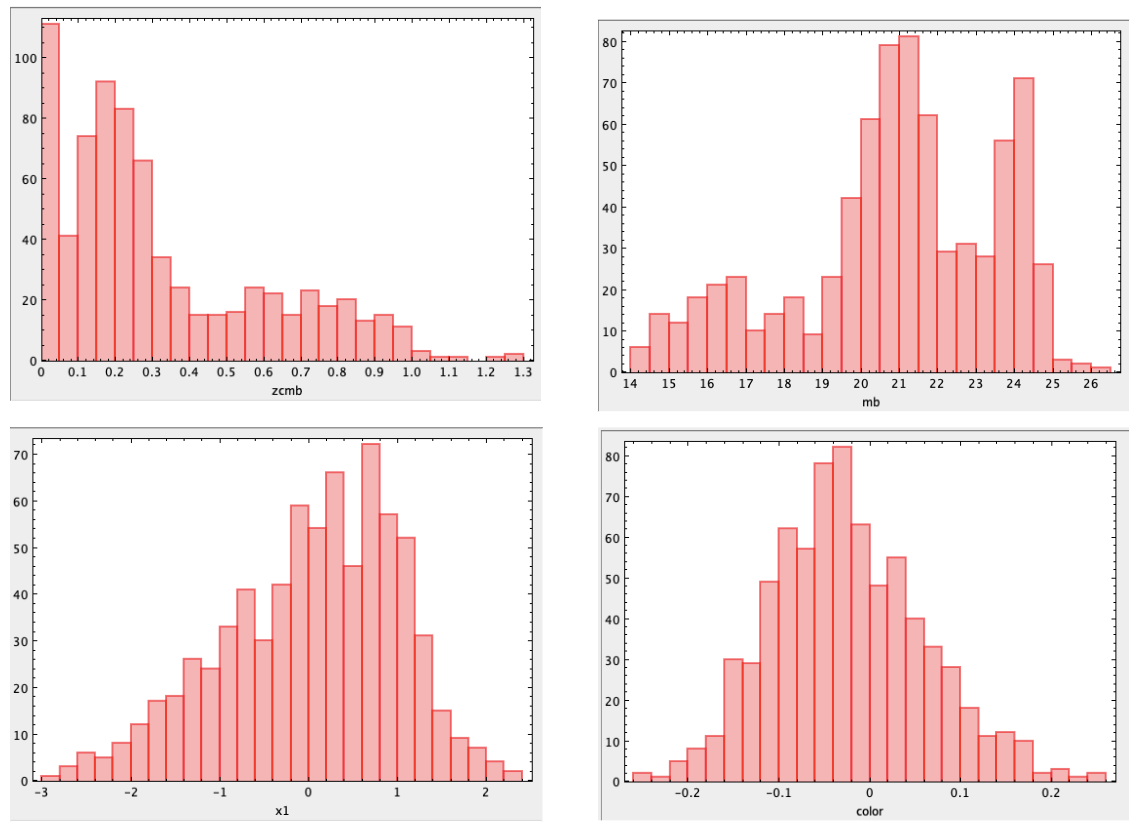


mb vs tmax

In [21]:
tmax = data['tmax']

max_tmax = max(tmax)
min_tmax = min(tmax)

print(min_tmax)
print(max_tmax)


48076.401017
54555.109466


In [22]:
import datetime

def mjd_to_date(mjd):
    """
    Convert Modified Julian Date to calendar date.
   
    Parameters:
    mjd (float): Modified Julian Date
   
    Returns:
    datetime.date: Calendar date in the format YYYY-MM-DD
    """
    # MJD reference date (1858-11-17)
    
    mjd_ref = datetime.date(1858, 11, 17)
   
    calendar_date = mjd_ref + datetime.timedelta(days=mjd)
   
    return calendar_date

In [23]:
mjd = min_tmax 
date = mjd_to_date(mjd)
print(f"The calendar date for MJD {mjd} is: {date}")

The calendar date for MJD 48076.401017 is: 1990-07-04


In [24]:
mjd = max_tmax
date = mjd_to_date(mjd)
print(f"The calendar date for MJD {mjd} is: {date}")

The calendar date for MJD 54555.109466 is: 2008-03-30


Below is a plot of apparent magntiude vs tmax

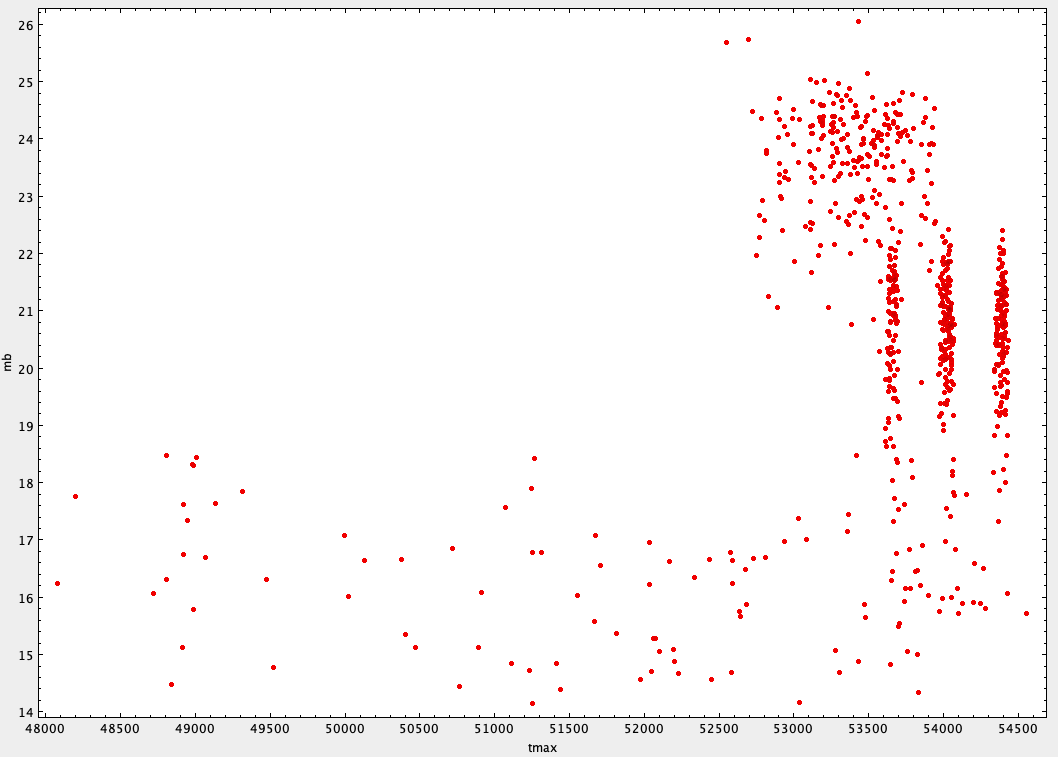

mb vs redshift with error bars

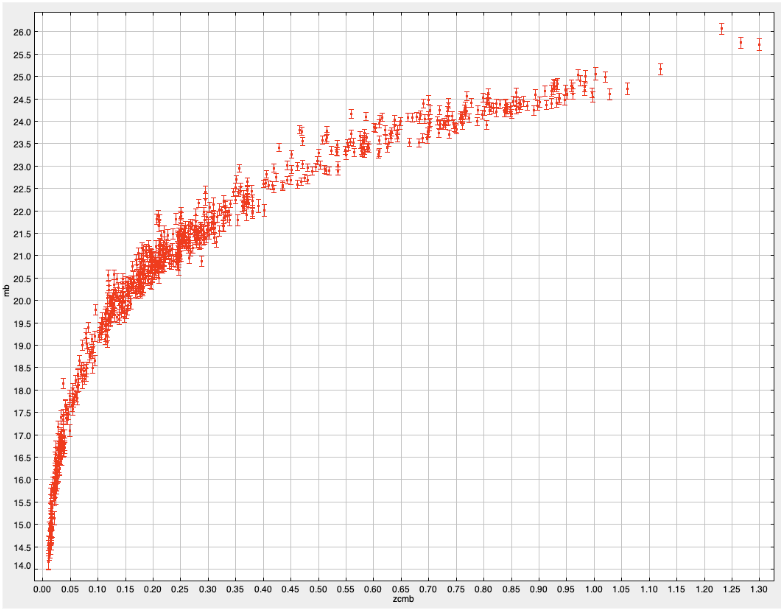

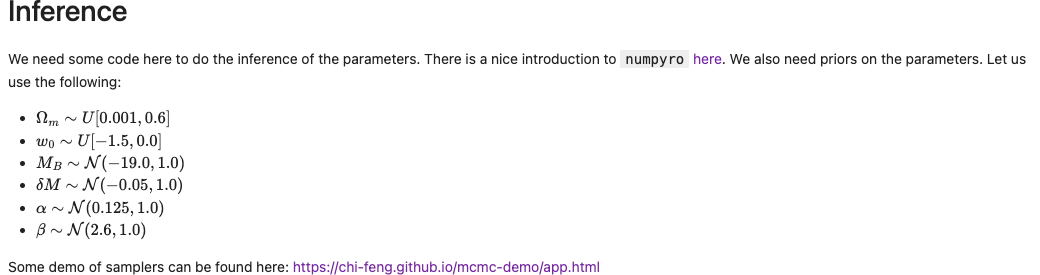

Please view notebook: playground_anna_mcmc